### Exercise 3

Construct a classification problem and a finite hypothesis class $\mathcal{H}$ to illustrate that the probability 

$$
p(\varepsilon) = \mathbb{P}\left(\sup_{f\in \mathcal{H}} \left|R_n(f)-R(f)\right|\geq \varepsilon\right)
$$

violates Hoeffding's inequality but satisfies the union bound. Proceed as follows:

1. Generate a large population dataset of size $N$ as ground truth
2. Construct a finite hypothesis class $\mathcal{H}$ 
3. Compute the true risk for all $f \in \mathcal{H}$ 
4. Choose a small sample size $n$
5. Repeat $T$ times:
    1. generate a training set of size $n$
    2. compute the empirical risk for all $f \in \mathcal{H}$ 
6. Estimate the probabilities $p(\varepsilon)$ as a function of $\varepsilon$.
7. Plot the distribution of deviations $\left|R_n(f)-R(f)\right|$ using a box- or violin plot.
8. Plot the Hoeffding and the union bound together with the estimates of $p(\varepsilon)$ as a function of $\varepsilon$.

---
### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

---
### Constants

In [2]:
N_DATA = int(1e6)   # size of population
N_FEATURES = 10     # number of features
N_HYPOS = 10        # number of hypotheses
CLUS_STD = 1.5      # standard deviation of clusters

---
### Data

The data is generated using sklearn's `make_blobs` with two clusters. One cluster centre is the origin and the other is the vector of all ones.

In [ ]:

# population 
X, y = make_blobs(n_samples=N_DATA, 
                  n_features=N_FEATURES, 
                  centers=[np.zeros(N_FEATURES), np.ones(N_FEATURES)], 
                  cluster_std=CLUS_STD)

# sampling function
def sample(n):
    X_train, _, y_train, _ = train_test_split(X, y, train_size=n)
    return X_train, y_train


---
### Hypothesis Class

The hypothesis class consists of randomly generated linear classifiers and their true risks. 

The error-method returns the empirical risk of each hypothesis on the specified training set.



In [3]:
class HypothesisClass:

    def __init__(self, X, y):
        # parameters of linear classifiers
        self.W = np.random.random((N_HYPOS, N_FEATURES)) - 0.5
        self.B = np.random.random((N_HYPOS, 1)) - 0.5
        # true risks of each hypothesis
        self.R = self.error(X, y)
        
    def error(self, X, y):
        # returns empirical / true risk
        y_pred = np.dot(self.W, X.T) + self.B
        y_pred = (y_pred >= 0).astype(int) 
        _y = np.tile(y, [N_HYPOS, 1])
        return (y_pred != _y).mean(axis=1)

---
### Auxiliary Functions

In [4]:
def run(n_sample=10, n_runs=100):
    hc = HypothesisClass(X, y)
    Rn = np.zeros((n_runs, N_HYPOS))
    for i in range(n_runs):
        X_train, y_train = sample(n_sample)
        Rn[i] = hc.error(X_train, y_train)
    return Rn, hc.R

def probs(Rn, R, eps):
    Pn = np.zeros(len(eps))
    for i, e in enumerate(eps):
        Pn[i] = np.sum(np.abs(Rn-R) >= e)/Rn.shape[0]
    return Pn

def violinplot(Rn, R):
    plt.violinplot(np.abs(Rn-R), showmeans=True)
    plt.show()

def boundplot(eps, n, Pn):

    # Hoeffding
    H = 2.*np.exp(-2.*n*(eps**2))

    # Union
    U = 2*N_HYPOS*np.exp(-2.*n*(eps**2))

    plt.plot(eps, Pn, lw=2, linestyle='-.', 
             label='$P(sup |R_n-R|\geq \epsilon)$')
    plt.plot(eps, H, lw=2, label='Hoeffding\'s bound')
    plt.plot(eps, U, lw=2, label='Union bound')
    plt.xlabel('$\epsilon$')
    plt.legend()
    plt.tight_layout()
    plt.show()

---
### Experiment

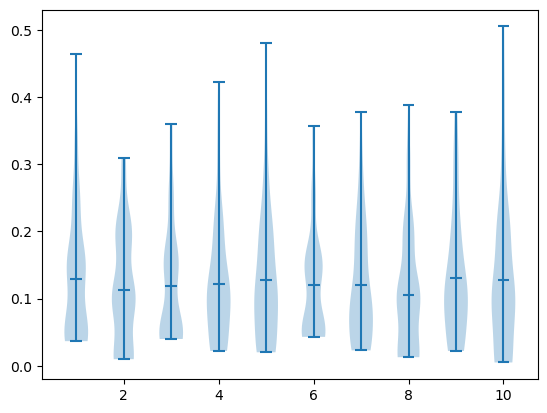

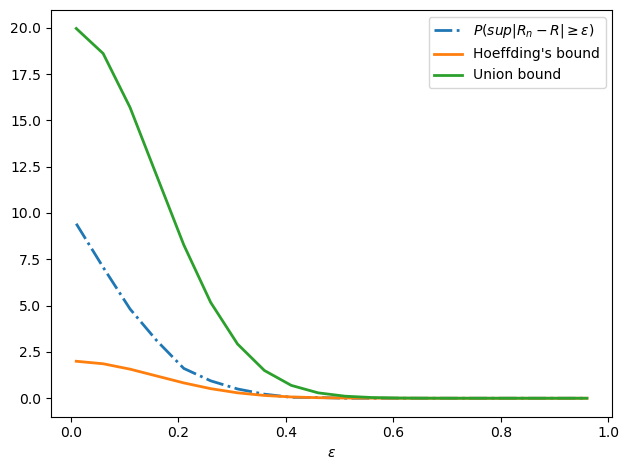

In [5]:
eps = np.arange(0.01, 1., 0.05)
n_sample = 10
n_runs = 100
Rn, R = run(n_sample, n_runs)
Pn = probs(Rn, R, eps)
violinplot(Rn, R)
boundplot(eps, n_sample, Pn)
